**Simple Dual Invesment _Backtest_**

Two kinds of Monte Carlo simulations:
* Generate returns from historic mean and std assuming a normal distribution (log normal should be better)
* Use actual past returns, and permute them for the MC backtesting (This is a simple permutation of .pct_change() of the close prices; to be more accurate we should use the permutation function used by Neurotrader)

In the remote case this _backtest_ is somehow accurate, we should play with the variables `pct_increase_sell_high` and `pct_decrease_buy_low` (which are the percentage difference in price from current price S_0 and strike price K) and ofc `apr_sell_high` and `apr_buy_low` (which are the yearly yields of sell high and buy low).
This, as expected, has a great impact on the results

In [121]:

import numpy as np
import pandas as pd


coin = "ETH"

btc_price_data = pd.read_parquet(f"data/ohlcv_{coin}USD_1d.parquet")
btc_price_close = btc_price_data["close"]




# We could simply use historial data instead of simulating the price

def simulate_btc_price(btc_price, returns_vector): 
    """
    Simulate the price of BTC over time given a vector of returns.
    """
    btc_price_vector = np.zeros(len(returns_vector))
    btc_price_vector[0] = btc_price
    for i in range(1, len(returns_vector)):
        btc_price_vector[i] = btc_price_vector[i-1] * (1 + returns_vector[i-1])
    return btc_price_vector

btc_price_vector = simulate_btc_price(btc_price_close.iloc[-1], returns_vector)



def simulate_dual_investment_roll(
    btc_price, returns_vector,
    btc_balance0=0.2, usdt_balance0=10_000.0,
    apr_sell_high=1.50,      # 150% APR on BTC-side DI
    apr_buy_low=1.50,        # 150% APR on USDT-side DI
    pct_increase_sell_high=1.02,  # target up: +2%
    pct_decrease_buy_low=0.98,    # target down: -2%
    alloc_btc=1.0,           # fraction of BTC balance deposited daily into Sell-High
    alloc_usdt=1.0,          # fraction of USDT balance deposited daily into Buy-Low
    fee_bps=0                # optional conversion fee (basis points) at settlement
):
    """
    Models *rolling 1-day Dual Investment* on BOTH legs each day.
    Each day t-1 -> t:
      - deposit alloc_btc * BTC into Sell-High with K_up
      - deposit alloc_usdt * USDT into Buy-Low with K_down
      - earn simple interest for one day on the deposited amounts
      - settle at t: convert at K if condition met; otherwise keep deposit currency (+interest)
      - leftover (non-deposited) funds sit idle (no interest) by default
    """
    # daily_sell = apr_sell_high / 365.0
    # daily_buy  = apr_buy_low  / 365.0

    daily_sell = (1 + apr_sell_high)**(1/365) - 1
    daily_buy  = (1 + apr_buy_low)**(1/365) - 1

    fee = fee_bps / 10_000.0

    # price path aligned so price[i] is day i price; returns_vector[i-1] drives price[i]
    price = simulate_btc_price(btc_price, returns_vector)
    n = len(price)

    btc_vec  = np.zeros(n)
    usdt_vec = np.zeros(n)
    tv_vec   = np.zeros(n)  # total value in USDT

    btc_vec[0]  = btc_balance0
    usdt_vec[0] = usdt_balance0
    tv_vec[0]   = btc_vec[0]*price[0] + usdt_vec[0]

    # record per-day deposits/interest for diagnostics
    logs = []

    for i in range(1, n):
        P_prev = price[i-1]
        P_cur  = price[i]
        K_up   = P_prev * pct_increase_sell_high
        K_dn   = P_prev * pct_decrease_buy_low

        # start from end-of-previous-day balances
        btc_bal  = btc_vec[i-1]
        usdt_bal = usdt_vec[i-1]

        # decide deposits for the 1-day DIs
        dep_btc  = alloc_btc  * btc_bal
        dep_usdt = alloc_usdt * usdt_bal

        # leave the rest idle (no interest unless you explicitly want it)
        idle_btc  = btc_bal  - dep_btc
        idle_usdt = usdt_bal - dep_usdt

        # simple interest for 1 day on deposited amounts
        rew_btc  = dep_btc  * daily_sell
        rew_usdt = dep_usdt * daily_buy

        # settle Sell-High (BTC deposit): if P_cur >= K_up -> convert BTC to USDT at K_up
        if P_cur >= K_up:
            # you deliver (dep_btc + rew_btc) BTC, receive USDT at strike K_up, minus fee
            usdt_from_sell = (dep_btc + rew_btc) * K_up * (1 - fee)
            out_btc_sell   = 0.0
        else:
            # not triggered: keep BTC (+interest)
            out_btc_sell   = (dep_btc + rew_btc)
            usdt_from_sell = 0.0

        # settle Buy-Low (USDT deposit): if P_cur <= K_dn -> convert USDT to BTC at K_dn
        if P_cur <= K_dn:
            # you spend (dep_usdt + rew_usdt) USDT to buy BTC at strike K_dn, minus fee
            btc_from_buy = ((dep_usdt + rew_usdt) * (1 - fee)) / K_dn
            out_usdt_buy = 0.0
        else:
            # not triggered: keep USDT (+interest)
            out_usdt_buy = (dep_usdt + rew_usdt)
            btc_from_buy = 0.0

        # end-of-day balances after both settlements + idle
        btc_end  = idle_btc  + out_btc_sell + btc_from_buy
        usdt_end = idle_usdt + usdt_from_sell + out_usdt_buy

        btc_vec[i]  = btc_end
        usdt_vec[i] = usdt_end
        tv_vec[i]   = btc_end * P_cur + usdt_end

        logs.append({
            "day": i,
            "P_prev": P_prev, "P_cur": P_cur,
            "K_up": K_up, "K_dn": K_dn,
            "dep_btc": dep_btc, "dep_usdt": dep_usdt,
            "rew_btc": rew_btc, "rew_usdt": rew_usdt,
            "trigger_sell_high": P_cur >= K_up,
            "trigger_buy_low":   P_cur <= K_dn,
            "btc_end": btc_end, "usdt_end": usdt_end, "tv_end": tv_vec[i]
        })

    df = pd.DataFrame({
        "price": price,
        "btc_balance": btc_vec,
        "usdt_balance": usdt_vec,
        "total_value_usdt": tv_vec
    })
    log_df = pd.DataFrame(logs)
    return df, log_df





def returns_vector_mc_cyclic(returns, n_permutations): 
    """
    Perform a cyclic permutation of the returns vector.
    Idea from Kevin J. Davey book "how to build algorithmic trading systems"
    Here it does not seem to be a good idea
    """
    returns = np.asarray(returns, dtype=float)
    n = len(returns)
    out = np.empty((n, n_permutations), dtype=float)
    for k in range(n_permutations):
        out[:, k] = np.roll(returns, k)
    return out




def returns_vector_mc_permutation(returns, n_permutations):
    """
    Perform a permutation of the returns vector.
    """
    returns = np.asarray(returns, dtype=float)
    n = len(returns)
    out = np.empty((n, n_permutations), dtype=float)
    out[:, 0] = returns
    for k in range(1, n_permutations):
        out[:, k] = np.random.permutation(returns)
    return out


def value_at_risk(returns, confidence_level=0.95):
    """
    Calculate the value at risk (VaR).
    """
    r = np.asarray(returns, dtype=float)
    return np.percentile(r, 100 * (1 - confidence_level))

def expected_shortfall(returns, confidence_level=0.95):
    """
    Calculate the expected shortfall (ES), or conditional value at risk (CVaR).
    """
    r = np.asarray(returns, dtype=float)
    var = value_at_risk(r, confidence_level)
    tail = r[r <= var]
    return np.mean(tail) if tail.size else np.nan  # handle all-positive case



i


0

Wins: 4, Losses: 196
Median return: -38.7988%, Mean return: -37.5575%, 5–95%: -63.90% … -8.45%
VaR 95.0%: -63.90%, CVaR 95.0%: -68.25%
Wins: 4, Losses: 196


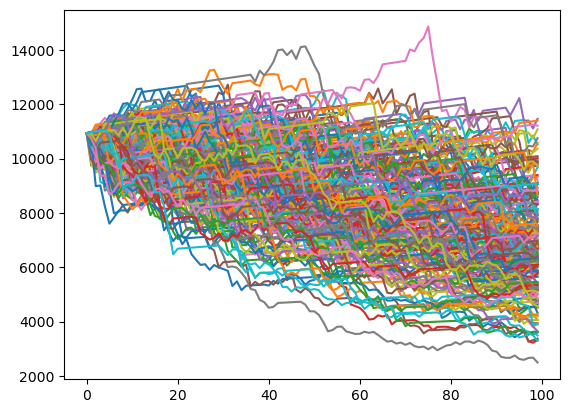

In [122]:
# HERE WE SIMULATE THE RETURNS VECTOR BASED ON HISTORICAL DATA
# SIMPLE NORMAL DISTRIBUTION 
# LOG NORMAL SHOULD BE BETTER BUT STILL NOT ACCURATE

iterations = 200

btc_returns = btc_price_close.pct_change()
btc_returns_mean = btc_returns.mean()
btc_returns_std = btc_returns.std()



returns_vector_mc = np.random.normal(loc=btc_returns_mean, scale=btc_returns_std, size=(100, iterations))


wins = losses = 0
pnl_list = []
ret_list = []

confidence_level = 0.95 # for VaR and ES

for i in range(iterations):
    df, _= simulate_dual_investment_roll(btc_price_close.iloc[-1], returns_vector_mc[:, i], apr_sell_high=1.0, apr_buy_low=1.0, pct_increase_sell_high=1.03, pct_decrease_buy_low=0.97, fee_bps=0)
    
    v0 = df["total_value_usdt"].iloc[0]
    vT = df["total_value_usdt"].iloc[-1]

    if vT > v0:
        wins += 1
    else:
        losses += 1
    pnl_list.append(vT - v0)
    ret_list.append(vT / v0 - 1)
    df["total_value_usdt"].plot()     
    # print(aa["total_value_usdt"])

print(f"Wins: {wins}, Losses: {losses}")
print(f"Median return: {np.median(ret_list):.4%}, "
      f"Mean return: {np.mean(ret_list):.4%}, "
      f"5–95%: {np.percentile(ret_list,5):.2%} … {np.percentile(ret_list,95):.2%}")
print(f"VaR {confidence_level*100}%: {value_at_risk(ret_list, confidence_level):.2%}, CVaR {confidence_level*100}%: {expected_shortfall(ret_list, confidence_level):.2%}")

print(f"Wins: {wins}, Losses: {losses}")

Wins: 0, Losses: 1
Median return: -99.9625%, Mean return: -99.9625%, 5–95%: -99.96% … -99.96%
VaR 95.0%: -99.96%, CVaR 95.0%: -99.96%


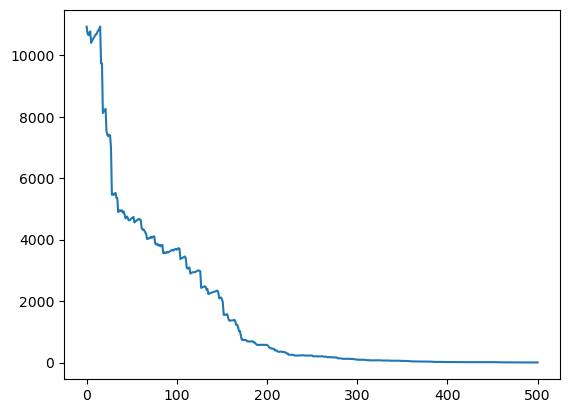

In [123]:
# HERE WE USE HISTORICAL RETURNS OF THE LAST nDays
# IF ITERATIONS = 1 WE USE THE EXACT RETURNS VECTOR
# OTHER ITERATIONS ARE JUST RANDOM PERMUTATIONS OF THE RETURNS VECTOR 
# THIS IS ALSO NOT ACCURATE


nDays = 1*365
returns = btc_price_close["2017-01-01":"2018-12-31"].pct_change().dropna().to_numpy()
# returns = btc_price_close[-nDays:].pct_change().dropna().to_numpy()

iterations = 1





# returns_vector_mc = returns_vector_mc_cyclic(returns, iterations)
returns_vector_mc = returns_vector_mc_permutation(returns, iterations)

wins = losses = 0
pnl_list = []
ret_list = []

confidence_level = 0.95 # for VaR and ES

for i in range(iterations):
    df, _= simulate_dual_investment_roll(
        btc_price_close.iloc[-1], returns_vector_mc[:, i], 
        apr_sell_high=4.379, apr_buy_low=4.379, 
        pct_increase_sell_high=1.0026, pct_decrease_buy_low=0.9974, 
        fee_bps=0)
    


    v0 = df["total_value_usdt"].iloc[0]
    vT = df["total_value_usdt"].iloc[-1]

    if vT > v0:
        wins += 1
    else:
        losses += 1
    pnl_list.append(vT - v0)
    ret_list.append(vT / v0 - 1)
    df["total_value_usdt"].plot()     
    # print(aa["total_value_usdt"])

print(f"Wins: {wins}, Losses: {losses}")
print(f"Median return: {np.median(ret_list):.4%}, "
      f"Mean return: {np.mean(ret_list):.4%}, "
      f"5–95%: {np.percentile(ret_list,5):.2%} … {np.percentile(ret_list,95):.2%}")
print(f"VaR {confidence_level*100}%: {value_at_risk(ret_list, confidence_level):.2%}, CVaR {confidence_level*100}%: {expected_shortfall(ret_list, confidence_level):.2%}")

